# Quasi-Newton methods: BFGS

In [1]:
import numpy as np
import jax
import jax.numpy as jnp
import scipy.optimize
import scipy as sp
import matplotlib.pyplot as plt

# We enable double precision in JAX
from jax.config import config
config.update("jax_enable_x64", True)

Consider the [Rosenbrock function](https://en.wikipedia.org/wiki/Rosenbrock_function), that is minimized in $\mathbf{x} = (1,1,\dots,1)^T$:

$$\mathcal{L}(\mathbf{x}) = \sum_{i=1}^{N-1} [100 (x_{i+1} - x_i^2 )^2 + (1-x_i)^2]$$

In [2]:
def loss(x):
    return sum(100.0 * (x[1:] - x[:-1]**2)**2 + (1 - x[:-1])**2)

Use `jax` to compute and compile the Rosenbrock function and its gradient.

In [3]:
loss_jit = jax.jit(loss)
grad_jit = jax.jit(jax.grad(loss))

Implement the BFGS method (with line search) for the minimization of the Rosenbrock function.
Set a maximum of 1000 epochs and a stopping tolerance on the gradient eucledian norm of $10^{-8}$. Employ an initial guess for $\mathbf{x}$ with random numbers in the interval $[0,2]$.

(0.000804768751551878, 12, 1, Array(6280.10700131, dtype=float64), Array(18182.38452843, dtype=float64), Array([ 178.98646727, -150.96891846,  234.31588915,  -82.10540977,
        107.02758039, -236.54660411,  502.11554631,   29.74382475,
       -270.28020528, 1190.28105255, -533.26096807,  344.8499817 ,
        996.1662252 , -349.40665224,  211.58253892,  -66.0587079 ,
        -12.41943151, -107.17029892,  587.91963497,  271.94647805,
       -340.48069314,   53.28669276,  929.57446252, -400.75102101,
         97.81161084,  -72.91659205,  183.61356337, -113.12868803,
        833.07559122, -233.8732037 ,   13.94933653, -210.85124564,
        628.49574369, -148.17876027, -116.38379004,   49.62185542,
         39.48944486,  880.98005744, -498.27064528,  435.71539794,
       -107.7993533 ,  209.84957559, -150.31806932,  -85.92820177,
        163.2760921 ,   -7.59605725,   32.49977264,  -89.6287663 ,
         -5.52187821,   18.30960473, -134.30539473, 1248.56583896,
       -335.36117787,  1

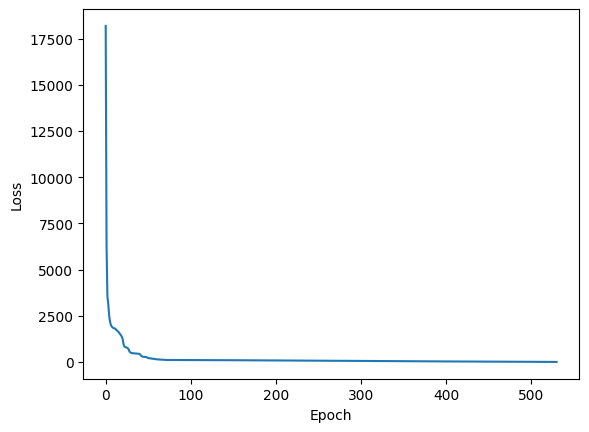

In [10]:
N = 100
max_epochs = 1000
tol = 1e-8

np.random.seed(0)
x = np.random.rand(N)*2

epoch = 0
alpha = 1
grad = grad_jit(x)
b_inv = jnp.eye(N)

history = [loss_jit(x)]

while np.linalg.norm(grad) and epoch < max_epochs:
    epoch += 1
    # search direction
    p = -b_inv @ grad
    
    # line search
    line_search = sp.optimize.line_search(loss_jit, grad_jit, x, p)
    print(line_search)
    alpha = line_search[0]
    x_new = x + alpha * p

    # computing s and y
    
    s = x_new - x
    grad_new = grad_jit(x_new)
    y = grad_new - grad
    
    # Sherman-Morrison update
    rho = 1 / (y @ s)
    E = jnp.eye(N) - rho * jnp.outer(y, s)
    b_inv = E.T @ b_inv @ E + rho * jnp.outer(s, s)
    
    # update
    x = x_new
    grad = grad_new
    history.append(loss_jit(x))

    print(f"Epoch {epoch}: loss = {history[-1]}")

plt.plot(history)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()